In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch.nn.functional as F
import numpy as np
import random

# 1. VAE

載入資料集

In [ ]:
# 超參數
batch_size = 128
lr = 1e-3  #學習率
epochs = 30
seed = 42 #隨機種子
torch.manual_seed(seed)

# VAE 專用資料轉換
transform = transforms.Compose([
    transforms.ToTensor(),    # 轉成 Tensor (C,H,W)=(1,28,28)
])

# MNIST 資料集
dataset = datasets.MNIST(
    root="./data",
    train=True,
    download=True,
    transform=transform
)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

100%|██████████| 9.91M/9.91M [00:00<00:00, 17.8MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 484kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.51MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 14.2MB/s]


模型設定

In [ ]:
class VAE(nn.Module):
  def __init__(self, input_dim=784, hidden_dim=400, latent_dim=20):
    super(VAE, self).__init__()
    # Encoder
    self.fc1 = nn.Linear(input_dim, hidden_dim)
    self.fc_mu = nn.Linear(hidden_dim, latent_dim)
    self.fc_logvar = nn.Linear(hidden_dim, latent_dim)

    # Decoder
    self.fc3 = nn.Linear(latent_dim, hidden_dim)
    self.fc4 = nn.Linear(hidden_dim, input_dim)

    self.relu = nn.ReLU()
    self.sigmoid = nn.Sigmoid()

  def encode(self, x):
    h = self.relu(self.fc1(x))
    return self.fc_mu(h), self.fc_logvar(h)

  def reparameterize(self, mu, logvar):
    std = torch.exp(0.5*logvar)
    eps = torch.randn_like(std)
    return mu + eps*std

  def decode(self, z):
    h = self.relu(self.fc3(z))
    return self.sigmoid(self.fc4(h))

  def forward(self, x):
    mu, logvar = self.encode(x)
    z = self.reparameterize(mu, logvar)
    recon_x = self.decode(z)
    return recon_x, mu, logvar

初始化模型與優化器與損失函數

In [ ]:
model = VAE()
optimizer = optim.Adam(model.parameters(), lr=lr)

### 損失函數
def loss_function(recon_x, x, mu, logvar):
  # BCE
  BCE = nn.functional.binary_cross_entropy(recon_x, x, reduction='sum')
  # KLD
  KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
  return BCE + KLD

訓練

In [ ]:
model.train()
for epoch in range(1, epochs+1):
  train_loss = 0
  for batch_idx, (data, _) in enumerate(dataloader):
    data = data.view(-1, 784)
    optimizer.zero_grad()
    recon_batch, mu, logvar = model(data)
    loss = loss_function(recon_batch, data, mu, logvar)
    loss.backward()
    train_loss += loss.item()
    optimizer.step()
  print(f'Epoch {epoch}, Average loss: {train_loss / len(dataset):.4f}')

Epoch 1, Average loss: 165.6817
Epoch 2, Average loss: 121.8054
Epoch 3, Average loss: 114.8626
Epoch 4, Average loss: 111.9616
Epoch 5, Average loss: 110.1205
Epoch 6, Average loss: 108.9645
Epoch 7, Average loss: 108.1110
Epoch 8, Average loss: 107.4610
Epoch 9, Average loss: 106.8871
Epoch 10, Average loss: 106.4715
Epoch 11, Average loss: 106.1059
Epoch 12, Average loss: 105.7801
Epoch 13, Average loss: 105.5475
Epoch 14, Average loss: 105.2672
Epoch 15, Average loss: 105.0512
Epoch 16, Average loss: 104.8593
Epoch 17, Average loss: 104.6260
Epoch 18, Average loss: 104.4972
Epoch 19, Average loss: 104.3295
Epoch 20, Average loss: 104.2407
Epoch 21, Average loss: 104.0871
Epoch 22, Average loss: 103.9238
Epoch 23, Average loss: 103.7849
Epoch 24, Average loss: 103.7048
Epoch 25, Average loss: 103.5804
Epoch 26, Average loss: 103.4759
Epoch 27, Average loss: 103.4056
Epoch 28, Average loss: 103.2898
Epoch 29, Average loss: 103.1843
Epoch 30, Average loss: 103.1419


隨機生成影像

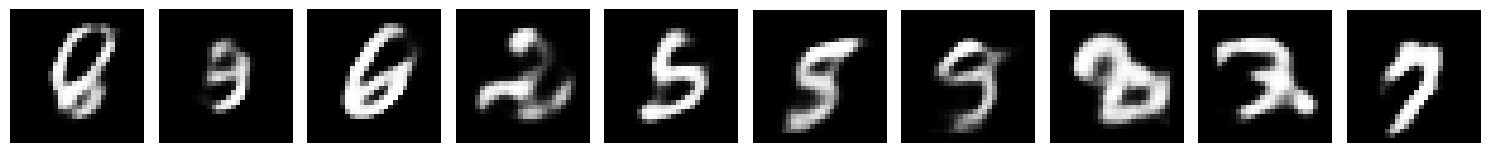

In [ ]:
model.eval()
with torch.no_grad():
    z = torch.randn(10, 20)  # latent_dim = 20
    sample = model.decode(z).cpu()
    sample = sample.view(-1, 1, 28, 28)
    # 將像素值從 [-1,1] 轉回 [0,1] 方便顯示
    sample = (sample + 1) / 2

# 顯示生成影像
fig, axes = plt.subplots(1, 10, figsize=(15,2))
for i in range(10):
    axes[i].imshow(sample[i].squeeze(), cmap='gray')
    axes[i].axis('off')
plt.tight_layout()

# 儲存生成影像
os.makedirs("results", exist_ok=True)
plt.savefig("results/VAE_MNIST_samples.png")
plt.show()

# 2. GAN

超參數設定

In [ ]:
batch_size = 128
z_dim = 100 #隨機噪聲向量維度
num_classes = 10 #MNIST 類別數（0~9）
lr = 2e-4  #學習率
epochs = 30
seed = 42 #隨機種子
torch.manual_seed(seed)

載入資料集

In [ ]:
#定義資料轉換transform
transform = transforms.Compose([
    transforms.ToTensor(), #影像轉成PyTorch Tensor
    transforms.Normalize([0.5], [0.5])  #將像素值從[0,1]轉為[-1,1]
])

dataset = datasets.MNIST(
    root="./data",        # Colab 可直接用 /content/data
    train=True,           # 訓練集
    download=True,        # 如果沒有就自動下載
    transform=transform
)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

模型設定

In [ ]:
## 定義 Generator
class Generator(nn.Module):
  def __init__(self, z_dim):
    super().__init__()
    self.model = nn.Sequential(
      nn.Linear(z_dim, 256),
      nn.LeakyReLU(0.2, inplace=True),
      nn.Linear(256, 512),
      nn.LeakyReLU(0.2, inplace=True),
      nn.Linear(512, 1024),
      nn.LeakyReLU(0.2, inplace=True),
      nn.Linear(1024, 28 * 28),
      nn.Tanh()
    )

  def forward(self, z):
    out = self.model(z)
    return out.view(-1, 1, 28, 28)

## 定義 Discriminator
class Discriminator(nn.Module):
  def __init__(self):
    super().__init__()
    self.model = nn.Sequential(
      nn.Linear(28 * 28, 512),
      nn.LeakyReLU(0.2, inplace=True),
      nn.Linear(512, 256),
      nn.LeakyReLU(0.2, inplace=True),
      nn.Linear(256, 1),
      nn.Sigmoid()
    )

  def forward(self, x):
    x = x.view(-1, 28 * 28)
    return self.model(x)

## 初始化網路與優化器
G = Generator(z_dim)
D = Discriminator()
criterion = nn.BCELoss()
opt_G = optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))
opt_D = optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))

模型訓練

In [ ]:
for epoch in range(epochs):
  for real_imgs, _ in dataloader:
    real_imgs = real_imgs
    batch_size_curr = real_imgs.size(0)

    # ===== 訓練 Discriminator =====
    noise = torch.randn(batch_size_curr, z_dim)
    fake_imgs = G(noise)

    smooth = 0.9
    real_labels = torch.ones(batch_size_curr, 1)* smooth
    fake_labels = torch.zeros(batch_size_curr, 1)

    D_real = D(real_imgs)
    D_fake = D(fake_imgs.detach())

    loss_D_real = criterion(D_real, real_labels)
    loss_D_fake = criterion(D_fake, fake_labels)
    loss_D = loss_D_real + loss_D_fake

    opt_D.zero_grad()
    loss_D.backward()
    opt_D.step()

    # ===== 訓練 Generator =====
    D_fake = D(fake_imgs)
    loss_G = criterion(D_fake, real_labels)  # 希望判為真

    opt_G.zero_grad()
    loss_G.backward()
    opt_G.step()

  print(f"Epoch [{epoch}/{epochs}] | Loss_D: {loss_D.item():.4f} | Loss_G: {loss_G.item():.4f}")

print("訓練完成！")

Epoch [0/30] | Loss_D: 1.1928 | Loss_G: 1.4273
Epoch [1/30] | Loss_D: 0.9025 | Loss_G: 1.5726
Epoch [2/30] | Loss_D: 0.8903 | Loss_G: 1.5533
Epoch [3/30] | Loss_D: 1.0722 | Loss_G: 1.0201
Epoch [4/30] | Loss_D: 0.9250 | Loss_G: 1.0634
Epoch [5/30] | Loss_D: 1.1111 | Loss_G: 2.5552
Epoch [6/30] | Loss_D: 0.8050 | Loss_G: 1.7917
Epoch [7/30] | Loss_D: 0.8281 | Loss_G: 1.4713
Epoch [8/30] | Loss_D: 1.0230 | Loss_G: 0.8240
Epoch [9/30] | Loss_D: 0.9919 | Loss_G: 1.3465
Epoch [10/30] | Loss_D: 0.8770 | Loss_G: 1.4910
Epoch [11/30] | Loss_D: 0.9389 | Loss_G: 1.5189
Epoch [12/30] | Loss_D: 1.1139 | Loss_G: 1.3346
Epoch [13/30] | Loss_D: 1.1546 | Loss_G: 0.8402
Epoch [14/30] | Loss_D: 1.1486 | Loss_G: 1.1180
Epoch [15/30] | Loss_D: 1.3716 | Loss_G: 1.8670
Epoch [16/30] | Loss_D: 1.2912 | Loss_G: 0.7862
Epoch [17/30] | Loss_D: 1.3684 | Loss_G: 0.7026
Epoch [18/30] | Loss_D: 1.1727 | Loss_G: 0.9516
Epoch [19/30] | Loss_D: 1.1495 | Loss_G: 0.8828
Epoch [20/30] | Loss_D: 1.1888 | Loss_G: 1.2660
Ep

生成10張影像與顯示

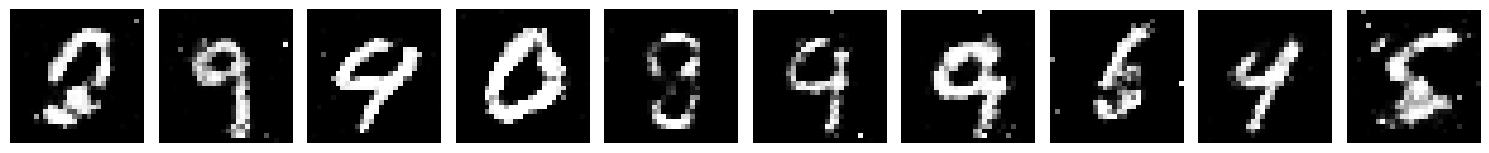

In [ ]:
G.eval()
with torch.no_grad():
    noise = torch.randn(10, z_dim)
    fake_images = G(noise).cpu()  # shape = (10, 1, 28, 28)

# 將像素值轉回 [0,1]
fake_images = (fake_images + 1) / 2

# 顯示 10 張影像
fig, axes = plt.subplots(1, 10, figsize=(15, 2))
for i in range(10):
    axes[i].imshow(fake_images[i].squeeze(), cmap="gray")
    axes[i].axis("off")
plt.tight_layout()

# 儲存圖片
os.makedirs("results", exist_ok=True)
plt.savefig("results/GAN_MNIST_samples.png")
plt.show()

# 3. cGAN

超參數設定

In [ ]:
batch_size = 128
z_dim = 100 #隨機噪聲向量維度
num_classes = 10 #MNIST 類別數（0~9）
lr = 2e-4  #學習率
epochs = 30
seed = 42 #隨機種子
torch.manual_seed(seed)

定義生成器Generator

In [ ]:
class Generator(nn.Module):
  def __init__(self, z_dim, num_classes, img_dim=28*28):
    super(Generator, self).__init__()
    # 將label轉為one-hot，再與z串接輸入
    self.model = nn.Sequential(
      nn.Linear(z_dim + num_classes, 256),
      nn.LeakyReLU(0.2),
      nn.Linear(256, 512),
      nn.LeakyReLU(0.2),
      nn.Linear(512, 1024),
      nn.LeakyReLU(0.2),
      nn.Linear(1024, img_dim),
      nn.Tanh()  #輸出範圍[-1,1]
    )

  def forward(self, z, labels):
    one_hot = torch.nn.functional.one_hot(labels, num_classes).float() #labels轉成one-hot向量
    x = torch.cat([z, one_hot], dim=1)  #拼接z + label
    img = self.model(x)
    return img.view(-1, 1, 28, 28)

定義判別器Discriminator

In [ ]:
class Discriminator(nn.Module):
  def __init__(self, num_classes, img_dim=28*28):
    super(Discriminator, self).__init__()
    self.model = nn.Sequential(
      nn.Linear(img_dim + num_classes, 512),
      nn.LeakyReLU(0.2),
      nn.Linear(512, 256),
      nn.LeakyReLU(0.2),
      nn.Linear(256, 1),
      nn.Sigmoid()  #輸出真假機率（越接近1越真）
    )

  def forward(self, img, labels):
    one_hot = torch.nn.functional.one_hot(labels, num_classes).float() #labels轉成one-hot向量
    img_flat = img.view(img.size(0), -1) #攤平成一維
    x = torch.cat([img_flat, one_hot], dim=1) #拼接影像與標籤
    return self.model(x)

初始化模型

In [ ]:
G = Generator(z_dim, num_classes)
D = Discriminator(num_classes)

criterion = nn.BCELoss()  #二元交叉熵損失，衡量真假判別的誤差
#建立Adam優化器
optimizer_G = optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D = optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))

訓練流程

In [ ]:
for epoch in range(epochs):
  for real_imgs, labels in dataloader:
    real_imgs, labels = real_imgs, labels
    batch_size_now = real_imgs.size(0)

    #建立真假標籤
    real = torch.full((batch_size_now, 1), 0.9)  #Label smoothing:真樣本=0.9
    fake = torch.zeros((batch_size_now, 1)) #假樣本的目標值是0

    #訓練Discriminator
    #真樣本
    outputs_real = D(real_imgs, labels)
    loss_real = criterion(outputs_real, real)

    #假樣本（由Generator生成）
    z = torch.randn(batch_size_now, z_dim) #隨機噪聲
    fake_labels = torch.randint(0, num_classes, (batch_size_now,))
    fake_imgs = G(z, fake_labels) #生成假影像
    outputs_fake = D(fake_imgs.detach(), fake_labels)
    loss_fake = criterion(outputs_fake, fake)

    #總損失
    loss_D = (loss_real + loss_fake) / 2
    optimizer_D.zero_grad() #清空梯度
    loss_D.backward() #反向傳播
    optimizer_D.step() #更新D的權重

    #訓練Generator
    #生成假影像
    z = torch.randn(batch_size_now, z_dim)
    fake_labels = torch.randint(0, num_classes, (batch_size_now,))
    fake_imgs = G(z, fake_labels)

    outputs = D(fake_imgs, fake_labels)
    loss_G = criterion(outputs, real)  #Generator希望被判為真

    optimizer_G.zero_grad() #清空梯度
    loss_G.backward() #反向傳播
    optimizer_G.step() #更新D的權重

  print(f"Epoch [{epoch+1}/{epochs}]  Loss_D: {loss_D:.4f}  Loss_G: {loss_G:.4f}")

Epoch [1/30]  Loss_D: 0.5054  Loss_G: 1.6617
Epoch [2/30]  Loss_D: 0.5552  Loss_G: 1.9431
Epoch [3/30]  Loss_D: 0.8691  Loss_G: 4.5496
Epoch [4/30]  Loss_D: 0.3996  Loss_G: 2.0337
Epoch [5/30]  Loss_D: 0.4023  Loss_G: 1.6596
Epoch [6/30]  Loss_D: 0.3008  Loss_G: 2.1521
Epoch [7/30]  Loss_D: 0.4976  Loss_G: 1.0446
Epoch [8/30]  Loss_D: 0.4573  Loss_G: 1.4942
Epoch [9/30]  Loss_D: 0.5840  Loss_G: 2.0968
Epoch [10/30]  Loss_D: 0.5434  Loss_G: 0.9132
Epoch [11/30]  Loss_D: 0.5038  Loss_G: 1.3619
Epoch [12/30]  Loss_D: 0.5585  Loss_G: 1.3244
Epoch [13/30]  Loss_D: 0.5404  Loss_G: 0.9790
Epoch [14/30]  Loss_D: 0.5590  Loss_G: 0.9820
Epoch [15/30]  Loss_D: 0.5991  Loss_G: 1.1272
Epoch [16/30]  Loss_D: 0.6207  Loss_G: 0.9350
Epoch [17/30]  Loss_D: 0.6000  Loss_G: 1.1667
Epoch [18/30]  Loss_D: 0.6276  Loss_G: 0.7218
Epoch [19/30]  Loss_D: 0.6371  Loss_G: 0.8046
Epoch [20/30]  Loss_D: 0.6291  Loss_G: 0.8400
Epoch [21/30]  Loss_D: 0.6232  Loss_G: 0.8832
Epoch [22/30]  Loss_D: 0.6385  Loss_G: 0.82

生成 0–9 各10張影像

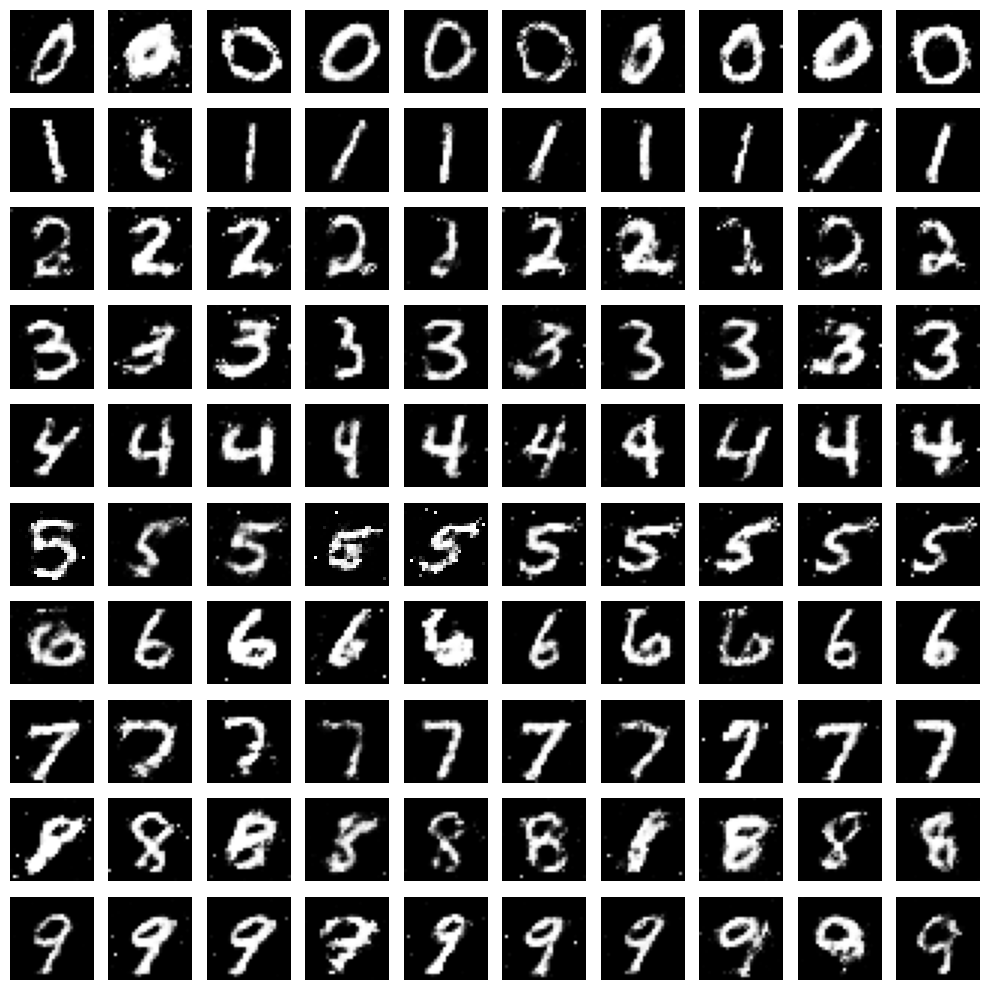

In [ ]:
G.eval() #推論模式
n = 10  #每個數字生成10張
fig, axes = plt.subplots(10, 10, figsize=(10,10))

for i in range(10):
  z = torch.randn(n, z_dim)
  labels = torch.full((n,), i, dtype=torch.long)
  imgs = G(z, labels).detach().cpu()

  for j in range(n):
    axes[i, j].imshow(imgs[j][0] * 0.5 + 0.5, cmap='gray')  #將[-1,1]還原成[0,1]
    axes[i, j].axis('off')

plt.tight_layout()
plt.savefig("cgan_result.png")
plt.show()

# Diffusion Model

1. 環境與超參數設定

In [ ]:
batch_size = 128
lr = 1e-4
epochs = 50
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

# 設定裝置
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


2. Diffusion: Forward (加噪) & Reverse (去噪公式)

In [ ]:
T = 1000  # 總 diffusion step
betas = torch.linspace(1e-4, 0.02, T).to(device)
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, dim=0)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1 - alphas_cumprod)

def forward_diffusion_sample(x0, t):
    """前向加噪: q(x_t | x_0)"""
    noise = torch.randn_like(x0)
    sqrt_alphas_t = sqrt_alphas_cumprod[t].view(-1,1,1,1)
    sqrt_one_minus_t = sqrt_one_minus_alphas_cumprod[t].view(-1,1,1,1)
    return sqrt_alphas_t * x0 + sqrt_one_minus_t * noise, noise

3. 小型 U-Net 模型 (簡化版)

In [ ]:
class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
    def forward(self, timestep):
        device = timestep.device
        half_dim = self.dim // 2
        emb = torch.log(torch.tensor(10000.0)) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
        emb = timestep[:, None] * emb[None, :]
        return torch.cat((torch.sin(emb), torch.cos(emb)), dim=-1)

class Block(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim, up=False):
        super().__init__()
        self.time_mlp = nn.Linear(time_emb_dim, out_ch)
        if up:
            self.conv1 = nn.Conv2d(in_ch*2, out_ch, 3, padding=1)
            self.transform = nn.ConvTranspose2d(out_ch, out_ch, kernel_size=4, stride=2, padding=1)  # 上採樣
        else:
            self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
            self.transform = nn.Conv2d(out_ch, out_ch, kernel_size=4, stride=2, padding=1)  # 下採樣
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.gnorm1 = nn.GroupNorm(8, out_ch)
        self.gnorm2 = nn.GroupNorm(8, out_ch)
        self.relu = nn.ReLU()

    def forward(self, x, t):
        h = self.gnorm1(self.relu(self.conv1(x)))
        time_emb = self.relu(self.time_mlp(t))[:, :, None, None]
        h = h + time_emb
        h = self.gnorm2(self.relu(self.conv2(h)))
        return self.transform(h)

class SimpleUNet(nn.Module):
    def __init__(self):
        super().__init__()
        image_channels = 1
        down_channels = (64, 128, 256)
        up_channels = (256, 128, 64)
        out_dim = 1
        time_emb_dim = 128

        self.time_mlp = nn.Sequential(
            SinusoidalPositionEmbeddings(time_emb_dim),
            nn.Linear(time_emb_dim, time_emb_dim * 2),
            nn.ReLU(),
            nn.Linear(time_emb_dim * 2, time_emb_dim)
        )


        self.conv0 = nn.Conv2d(image_channels, 64, 3, padding=1)
        self.downs = nn.ModuleList([
            Block(down_channels[i], down_channels[i+1], time_emb_dim)
            for i in range(len(down_channels)-1)
        ])
        self.ups = nn.ModuleList([
            Block(up_channels[i], up_channels[i+1], time_emb_dim, up=True)
            for i in range(len(up_channels)-1)
        ])
        self.output = nn.Conv2d(64, out_dim, 1)

    def forward(self, x, timestep):
        t = self.time_mlp(timestep)
        x = self.conv0(x)
        residuals = []
        for down in self.downs:
            x = down(x, t)
            residuals.append(x)
        for up in self.ups:
            residual = residuals.pop()
            # 強制對齊 residual 尺寸
            x = F.interpolate(x, size=residual.shape[2:], mode="nearest")
            x = torch.cat((x, residual), dim=1)
            x = up(x, t)
        return self.output(x)

4. 訓練

In [ ]:
# 訓練設定
model = SimpleUNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr)

def get_loss(model, x0, t):
    x_noisy, noise = forward_diffusion_sample(x0, t)
    noise_pred = model(x_noisy, t)
    return F.mse_loss(noise_pred, noise)

# 開始訓練
for epoch in range(epochs):
    for step, (x, _) in enumerate(dataloader):
        x = x.to(device)
        t = torch.randint(0, T, (x.shape[0],), device=device).long()
        loss = get_loss(model, x, t)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}/{epochs} | Loss: {loss.item():.4f}")

Epoch 1/50 | Loss: 0.0393
Epoch 2/50 | Loss: 0.0319
Epoch 3/50 | Loss: 0.0358
Epoch 4/50 | Loss: 0.0316
Epoch 5/50 | Loss: 0.0197
Epoch 6/50 | Loss: 0.0378
Epoch 7/50 | Loss: 0.0306
Epoch 8/50 | Loss: 0.0281
Epoch 9/50 | Loss: 0.0278
Epoch 10/50 | Loss: 0.0242
Epoch 11/50 | Loss: 0.0234
Epoch 12/50 | Loss: 0.0276
Epoch 13/50 | Loss: 0.0238
Epoch 14/50 | Loss: 0.0253
Epoch 15/50 | Loss: 0.0305
Epoch 16/50 | Loss: 0.0269
Epoch 17/50 | Loss: 0.0257
Epoch 18/50 | Loss: 0.0302
Epoch 19/50 | Loss: 0.0366
Epoch 20/50 | Loss: 0.0269
Epoch 21/50 | Loss: 0.0277
Epoch 22/50 | Loss: 0.0295
Epoch 23/50 | Loss: 0.0226
Epoch 24/50 | Loss: 0.0279
Epoch 25/50 | Loss: 0.0262
Epoch 26/50 | Loss: 0.0213
Epoch 27/50 | Loss: 0.0276
Epoch 28/50 | Loss: 0.0278
Epoch 29/50 | Loss: 0.0272
Epoch 30/50 | Loss: 0.0252
Epoch 31/50 | Loss: 0.0262
Epoch 32/50 | Loss: 0.0227
Epoch 33/50 | Loss: 0.0175
Epoch 34/50 | Loss: 0.0168
Epoch 35/50 | Loss: 0.0189
Epoch 36/50 | Loss: 0.0313
Epoch 37/50 | Loss: 0.0289
Epoch 38/5

5. 生成圖片

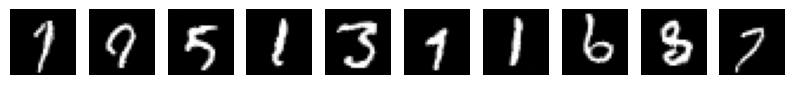

In [ ]:
@torch.no_grad()
def sample_plot_image():
    img = torch.randn((1, 1, 28, 28), device=device)
    for i in range(T-1, 0, -1):
        t = torch.full((1,), i, device=device, dtype=torch.long)
        eps_theta = model(img, t)
        alpha_t = alphas_cumprod[t].view(-1,1,1,1)
        alpha_prev = alphas_cumprod[t-1].view(-1,1,1,1) if i > 1 else torch.tensor(1.0, device=device)
        beta_t = betas[t].view(-1,1,1,1)

        mean = (1 / torch.sqrt(alphas[t]).view(-1,1,1,1)) * (img - beta_t / torch.sqrt(1-alpha_t) * eps_theta)
        if i > 1:
            noise = torch.randn_like(img)
            posterior_var = beta_t * (1 - alpha_prev) / (1 - alpha_t)
            img = mean + torch.sqrt(posterior_var) * noise
        else:
            img = mean
    return img

# 生成 10 張隨機圖片
plt.figure(figsize=(10,2))
for i in range(10):
    sample = sample_plot_image()
    plt.subplot(1,10,i+1)
    plt.imshow(((sample.cpu().squeeze() + 1) / 2).clamp(0,1), cmap="gray")
    plt.axis("off")
plt.show()